# [GD-6] 모든 장르 간 편향성 측정해 보기

# Step 0. 라이브러리 불러오기
---

In [35]:
import konlpy
import gensim
import sklearn
import seaborn
import matplotlib as plt
import matplotlib.pyplot as plt

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


# Step 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기
---

`synopsis.txt`에는 2001년부터 2019년 8월까지 제작된 영화들의 시놉시스 정보가 있다.  
`synopsis.txt`의 일부를 읽어보자.

In [2]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

`KoNLRy 패키지(한국어 형태소 분석기)`를 이용하여 품사가 명사인 경우만 남겨 `tokenized`라는 변수명으로 저장해보자.

In [3]:
# ⏳ 시간이 꽤나 걸림.....

from konlpy.tag import Okt

okt = Okt()
tokenized = []

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [4]:
print(len(tokenized))

71156


- 총 `71,156개`의 명사가 추출되어 `tokenized` 변수에 담겨있는 것을 확인할 수 있다.

# Step 2. 추출된 결과로 embedding model 만들기
---

`tokenized`에 담긴 데이터를 가지고 `word2vec`을 생성해보자.

In [5]:
from gensim.models import Word2Vec

model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)

'영화'라는 단어와 가장 유사한 단어들을 출력해보자.

In [6]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.895609974861145),
 ('다큐멘터리', 0.8552045822143555),
 ('드라마', 0.8300550580024719),
 ('영화로', 0.8179252743721008),
 ('형식', 0.7855992317199707),
 ('코미디', 0.7832702994346619),
 ('감동', 0.7737100124359131),
 ('주제', 0.7675084471702576),
 ('편의', 0.7598992586135864),
 ('판타지', 0.7568379640579224)]

`word2vec`이 잘 훈련된 것 같은지 다른 단어로도 확인해보자.

In [7]:
model.wv.most_similar(positive=['사랑'])

[('행복', 0.6991777420043945),
 ('애정', 0.696853756904602),
 ('만인', 0.6791136860847473),
 ('만남', 0.6785039305686951),
 ('첫사랑', 0.6663870811462402),
 ('진심', 0.6550351977348328),
 ('연애', 0.6542443633079529),
 ('우정', 0.6530421376228333),
 ('열정', 0.6523393392562866),
 ('이별', 0.6481666564941406)]

In [8]:
model.wv.most_similar(positive=['연기'])

[('시나리오', 0.8637000322341919),
 ('니웨', 0.8602733612060547),
 ('배우', 0.8530630469322205),
 ('연극', 0.8391590714454651),
 ('여배우', 0.8337424397468567),
 ('출연', 0.822689414024353),
 ('팬', 0.8179556727409363),
 ('소설', 0.815588653087616),
 ('스타일', 0.8148877620697021),
 ('샤오홍', 0.8106139898300171)]

- 전반적으로 유사한 단어들이 출력되었다.
- word2vec이 잘 훈련된 것을 확인할 수 있다.

# Step 3. TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
---

## 3.1 영화 구분 데이터의 단어 셋

In [9]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

`synopsis_art.txt(예술영화)`, `synopsis_gen.txt(일반영화(상업영화))` 두 파일을 읽어보자.

In [10]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

`KoNLRy 패키지`를 이용하여 품사가 명사인 경우만 남겨 `tokenized`에 저장하는 `read_token` 함수를 정의해보자.

In [11]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

print("슝~")

슝~


`read_token` 함수를 사용하여 품사가 명사인 경우만을 추출하여 `art`, `gen` 변수에 할당해보자.

In [12]:
# ⏳ 시간이 꽤나 걸림.....222
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [13]:
art[:3]

'사운드'

In [14]:
gen[:3]

'유사 '

`WEAT score` 계산을 위해 총 4개의 단어셋(X, Y, A, B)이 필요한데, 각 단어 셋을 가장 잘 대표할 수 있는 단어들을 선정해야 한다.  
그래서 코퍼스에서 자주 나타나는 (TF가 높은) 단어지만, 다른 코퍼스에는 많이 나오지 않는(IDF가 높은) 단어를 선정하는 `TF-IDF 방식`을 사용해보자.

In [15]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [16]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF가 높은 순으로 정렬된 art, gen 단어셋의 단어들을 출력해보자.

In [17]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

- 예술영화와 일반영화를 대표하는 단어가 중복되는 것들이 많은 것을 확인할 수 있다.

두 개념축이 대조되도록 대표하는 단어 셋을 만들어야 하기에, 중복되는 단어를 제외하고 상위 n개의 단어를 추출해보자.

In [18]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

추출된 단어를 확인해보자.

In [19]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [20]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


## 3.2 영화 장르 데이터의 단어 셋

전체 장르별 대표 단어를 추출해보자.

In [21]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

`read_token` 함수를 사용하여 품사가 명사인 경우만을 추출하여 `genre` 변수에 할당하자.

In [22]:
# ⏳ 시간이 꽤나 걸림.....333
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


`TF-IDF 방식`으로 장르 별 대표 단어셋을 구성해보자

In [23]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


TF-IDF가 높은 순으로 정렬된 각 장르 별 단어셋의 단어들을 출력해보자.

In [24]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

# Step 4. WEAT score 계산과 시각화
---

- 영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해보고 이를 Heatmap형태로 시각화해보자.
- 편향성이 두드러지는 영화 장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 더더욱 좋음😎😎

> * target_X : art (예술영화)
> * target_Y : gen (일반영화)
> * attribute_A, attribute_B는 여러 장르를 바꿔가며 구해보기

In [25]:
import numpy as np
from numpy import dot
from numpy.linalg import norm 

print("슝~")

슝~


### 💡 WEAT score란?  
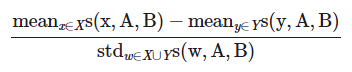   
- 두 벡터의 유사도를 측정하기 위해서 `cosine similarity(코사인 유사도)`를 이용한다.
- target에 있는 단어가 두 attribute 셋에 속한 단어들과의 유사도의 평균(mean)값이 얼마나 차이 나는지 측정한다.
- 개별단어가 개념축(attribute_A, B)에 대해 가지는 편향성을 계산한 값이다.
- X, Y에 속하는 모든 단어들이 가지는 편향성의 값의 표준편차(std)로 normalize한 값이 최종 WEAT score가 된다.

우선 `cosine similarity(코사인 유사도)`를 구하는 함수를 정의해보자.

In [26]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

`WEAT score` 공식에서 '분자'에 해당하는 부분을 계산하는 함수를 정의해보자.

In [27]:
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B  #, c_a, c_b

`WEAT score` 전체를 구하는 함수를 정의해보자.

In [28]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

`genre_name`의 길이(21x21)만큼 0으로 채운 매트릭스 형태로 표현한 `matrix`를 만들어보자.  
(추후 구한 결과를 `matrix`라는 변수에 담을 예정이다.)

In [29]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
matrix

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0,

각 영화 장르 별로 구한 `WEAT score`의 값을 `matrix`에 각각 할당한다.

In [30]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("슝~")

슝~


2개의 장르의 WEAT score값을 확인해보자.  
(WEAT score가 0.8이상, -0.8이하인 경우만 해석해보자.)

In [31]:
for i in range(len(genre_name)-1):
    print('[ attribute_A =', genre_name[i], ']')
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])
    print('----------------')

[ attribute_A = SF ]
SF 가족 -0.4879739
SF 공연 -0.35346186
SF 공포(호러) -0.66683924
SF 기타 0.3480303
SF 다큐멘터리 0.5871582
SF 드라마 -0.3795899
SF 멜로로맨스 -0.7850382
SF 뮤지컬 0.34880376
SF 미스터리 -0.6827684
SF 범죄 -0.2667837
SF 사극 -0.82425433
SF 서부극(웨스턴) -0.38059044
SF 성인물(에로) -0.5523646
SF 스릴러 -0.5241377
SF 애니메이션 0.38467973
SF 액션 -0.46873453
SF 어드벤처 -0.7927469
SF 전쟁 0.22039583
SF 코미디 -0.45410568
SF 판타지 -0.16096953
----------------
[ attribute_A = 가족 ]
가족 공연 0.18785042
가족 공포(호러) -0.15257666
가족 기타 0.7164788
가족 다큐멘터리 0.80873317
가족 드라마 0.19925024
가족 멜로로맨스 -0.6213662
가족 뮤지컬 0.68801814
가족 미스터리 -0.3137019
가족 범죄 0.16356832
가족 사극 -0.08961515
가족 서부극(웨스턴) 0.44039783
가족 성인물(에로) -0.29959807
가족 스릴러 -0.14832461
가족 애니메이션 0.85056174
가족 액션 0.075874016
가족 어드벤처 -0.05620922
가족 전쟁 0.61068493
가족 코미디 0.18518025
가족 판타지 0.4279365
----------------
[ attribute_A = 공연 ]
공연 공포(호러) -0.2482458
공연 기타 0.90740204
공연 다큐멘터리 0.9011139
공연 드라마 -0.027605211
공연 멜로로맨스 -0.71636254
공연 뮤지컬 0.8796735
공연 미스터리 -0.3678942
공연 범죄 0.034049243
공연 사극 -0.4067

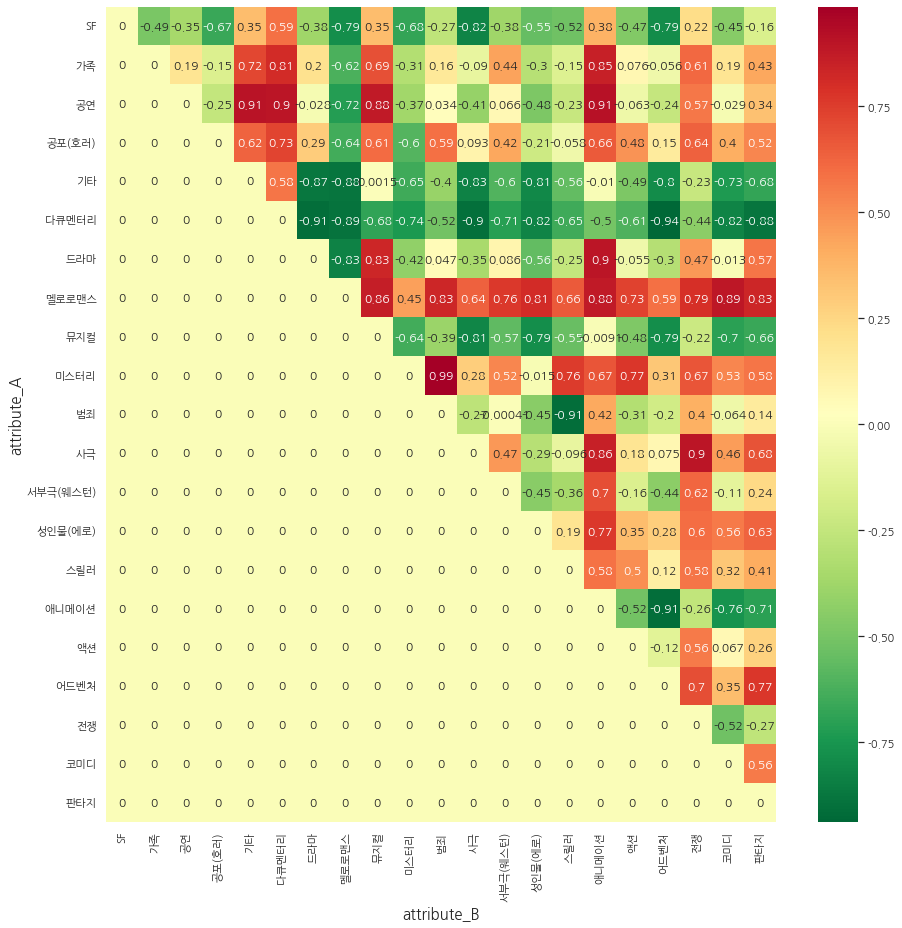

In [37]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (15,15)

sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')

plt.ylabel('attribute_A', fontsize = 15)
plt.xlabel('attribute_B', fontsize = 15)

plt.show()

# 😎 결과
---

## 1) 수치에 대한 결과
### `WEAT score`가 0.8, -0.8 이상인 것들만 따로 정리해보았다.

SF 사극 -0.82425433  

가족 다큐멘터리 0.80873317  
가족 애니메이션 0.85056174  

공연 기타 0.90740204  
공연 다큐멘터리 0.9011139  
공연 뮤지컬 0.8796735  
공연 애니메이션 0.9107156  
  
기타 드라마 -0.8708813  
기타 멜로로맨스 -0.88283134  
기타 사극 -0.828369  
기타 성인물(에로) -0.8074588  

다큐멘터리 드라마 -0.91015273  
다큐멘터리 멜로로맨스 -0.88926524  
다큐멘터리 사극 -0.90386945    
다큐멘터리 성인물(에로) -0.82142603  
다큐멘터리 어드벤처 -0.938393  
다큐멘터리 코미디 -0.8211871  
다큐멘터리 판타지 -0.88028914  

드라마 멜로로맨스 -0.8271606  
드라마 뮤지컬 0.83073163  
드라마 애니메이션 0.8984497  

멜로로맨스 뮤지컬 0.8607259  
멜로로맨스 범죄 0.8287908  
멜로로맨스 성인물(에로) 0.80746454  
멜로로맨스 애니메이션 0.87757486  
멜로로맨스 코미디 0.8923754  
멜로로맨스 판타지 0.8321987  

뮤지컬 사극 -0.8116393  

미스터리 범죄 0.9851281  

범죄 스릴러 -0.91295844  
 
사극 애니메이션 0.85636026  
사극 전쟁 0.8985836  

애니메이션 어드벤처 -0.9086907  

| SF | 가족 | 공연 | 공포(호러) | 기타 | 다큐멘터리 | 드라마 | 멜로로맨스 | 뮤지컬 | 미스터리 | 범죄 | 사극 | 서부극(웨스턴) | 성인물(에로) | 애니메이션 | 액션 | 어드벤처 | 전쟁 | 코미디 | 판타지 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 일반 | 예술 | 예술 | - | 일반 | 일반 | 예술(일반) | 예술 | 일반 | 예술 | 일반 | 예술 | - | 예술 | 일반 | - | 예술 | 일반 | - | 일반 |

- attribute_A가 `드라마` 장르인 경우를 제외한 나머지 장르 모두 `WEAT score`가 0.8, -0.8 넘었을 때의 결과가 명확하게 예술영화/일반영화로 나뉜다.
- `드라마` 장르의 경우, `멜로로맨스` 장르와 비교하였을 땐 `일반영화`이지만, 다른 장르와 비교하였을 땐 `예술영화`이다.
- 이것은 `멜로로맨스`장르의 수치를 보면 압도적으로 `예술영화`에 가깝기 때문에, `드라마` 장르가 `일반영화`로 수치가 향하는 것을 확인할 수 있다.
- `공포(호러)` 장르와 `서부극(웨스턴)` 장르는 유의미한 수치(0.8 이상, -0.8 이하)가 없기에 명확하게 영화를 구분할 수 없다.

## 2) 히트맵에 대한 결과

- 히트맵을 가로로 보면 대략적인 장르 별 영화 구분이 보인다.
- 대부분 초록색으로 채워진 장르는 `일반 영화`에 가깝고 붉은 색으로 채워진 장르는 `예술 영화`에 가깝다.
- 하지만 `WEAT score`가 0.8, -0.8 이하인 경우는 결과에 참고하지 않기 때문에 진한 색으로 표시된 수치의 색으로만 확인해보는 것이 좋다.

# 🌞 회고
---

## 1) 여러 시도
- 영화 구분 별 단어 셋과 장르 별 단어 셋의 갯수를 15개로 지정하여 프로젝트를 진행하였다. (해당 노트북)
- 그러다 단어 셋들의 단어 갯수를 늘리면 결과가 어떻게 달라질까 문득 궁금해져서 조금 늘려서 시도해보았다.
- 시도해본 결과, 각 장르 별 편향성이 현저하게 줄어 영화 구분을 하기 어려운 영화 장르들이 꽤나 나타났다.
- 하지만 기존에 편향성을 띄는 장르는 동일한 영화 구분의 결과가 나타났다.
- 혹시나 각 단어 셋의 단어 갯수가 더 많으면 어떨까 하여 단어 갯수를 50개로 더 늘려서 진행해보았다.
- 그 결과 더욱 편향성은 옅어지고 극히 드물게 0.8 이상인 값이 있었다.
- 단어의 갯수를 늘리면 안되는 것인지, 그것에 대한 명확한 지식이 없어서 선뜻 결론을 내릴 수 없는 것이 아쉬웠다.

### 각 단어셋의 단어를 30개로 지정하였을 때
- [관련 주피터 노트북](https://github.com/aramssong/AIFFEL-NLP/blob/main/%5BGD-3%5D%20WEAT%20score/%5BGD-6%5D%20WEAT%20score_2.ipynb)
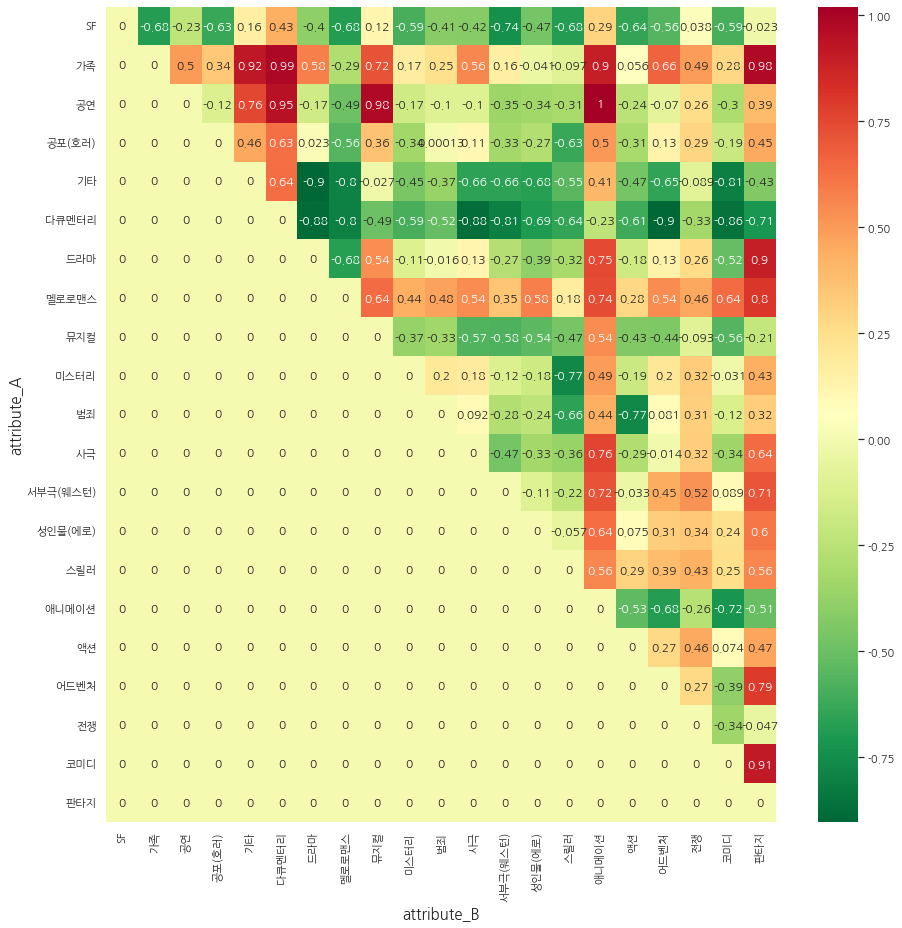

### 각 단어셋의 단어를 50개로 지정하였을 때
- [관련 주피터 노트북](https://github.com/aramssong/AIFFEL-NLP/blob/main/%5BGD-3%5D%20WEAT%20score/%5BGD-6%5D%20WEAT%20score_3.ipynb)
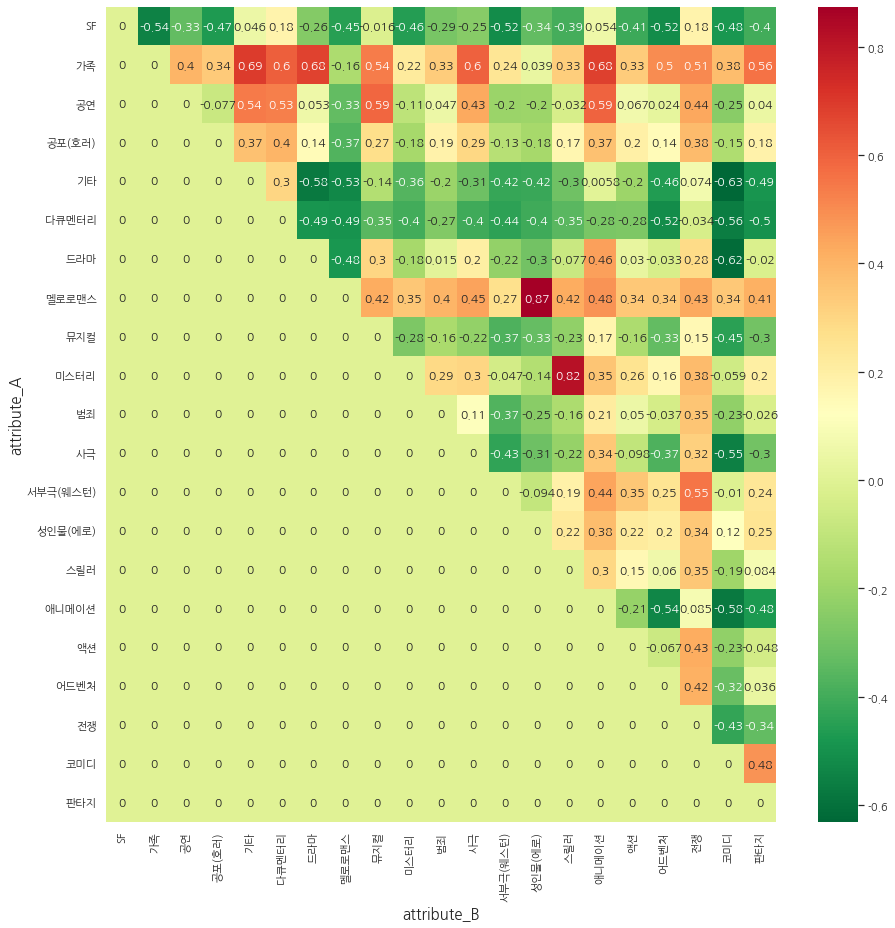

## 2) 후기
- 사람들마다 생각, 언어, 말, 글 등에 편향성이 있고 그것이 어떤 분야에 자리잡게 되면 고정관념이 된다는 것은 알고 있었지만, 이것이 워드 임베딩에 영향을 미친다는 것까지는 생각하지는 못하였다.
- 이런 편향성을 가진 데이터로는 인공지능 역시 편향이 될 수 밖에 없기에 이 편향성을 줄이는 것이 매우 중요하다는 것을 이번 프로젝트를 통해서 알게 되었다.
- 이번 프로젝트에서 여러 시도를 해보면서 정확한 결론을 도출하는 것이 매우 어려웠다.
- 어떻게 결론을 내려야 할 지 아직도 잘 모르겠는데, 이것에 대해 좀 더 상세하게 알고 싶어졌다.